# Adaptive Density Estimation By Bayesian Averaging (ADEBA)

In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from matplotlib import pyplot as plt
import math

## Creating a toy Data

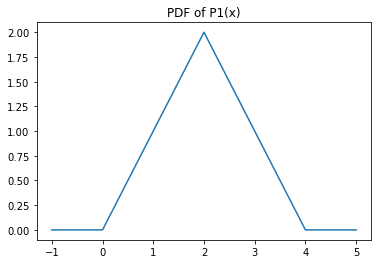

In [2]:
def f1(x):
    if(x>=0 and x<2):
        return x
    elif(x>=2 and x<4):
        return 4-x
    else:
        return 0

x = np.arange(-1, 6)
f1_dist = np.vectorize(f1)
p1 = f1_dist(x)
plt.plot(x, p1)
plt.title('PDF of P1(x)')
plt.show()

In [3]:
def sample_generator(pdf , N , a, b):
    sample = np.linspace(a, b, N)
    prob = []
    normalizer = 0
    for x in sample:
        p = pdf(x)
        normalizer += p
        prob.append(p)
    prob = prob / normalizer
    return np.random.choice(sample, p=prob, size=N)

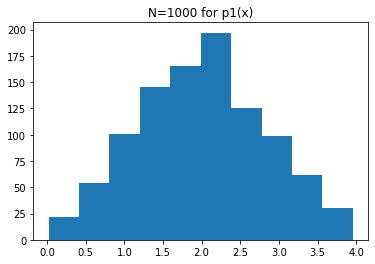

In [4]:
f1_sample = sample_generator(f1, 1000, 0, 6)
plt.hist(f1_sample)
plt.title('N=1000 for p1(x)')
plt.show()

In [5]:
mean = [1, 1, 0]
cov = [[4, 1, -1], [1,2,1], [-1, 1, 2]]
f2_sample = np.random.multivariate_normal(mean, cov, 10000)

## Data preprocessing

In [6]:
def preprocess(X):
    X = StandardScaler().fit_transform(X)
    pca = PCA(whiten=True)
    whitened = pca.fit_transform(X)
    return whitened

In [7]:
p = preprocess(np.array(f1_sample).reshape(-1,1))
np.cov(p.flatten())

array(1.)

In [8]:
p = preprocess(np.array(f2_sample))
np.round(np.cov(p, rowvar=False))

array([[ 1., -0., -0.],
       [-0.,  1.,  0.],
       [-0.,  0.,  1.]])

## defining ADEBA

In [9]:
class ADEBA:
    def __init__(self, pilot=None, beta=None, T=1000, prior='uniform'):
        self.pilot= pilot
        self.prior = prior
        self.beta = beta
        self.T = T
        self.alpha=None
        self.pca = PCA(whiten=True)
        self.scaler = StandardScaler()
        
        
    def _initialize(self, X):
        X = self.scaler.fit_transform(X)
        whitened = self.pca.fit_transform(X)
        return whitened
    
    def EstimateDensity(self, X):
        transformed_data = self._initialize(X)
        if self.pilot == None:
            self.pilot = np.ones(X.shape)
        for i in range(self.T):
            A, W = self._findintegration(transformed_data, self.beta)
            self.pilot = self._calculatePDF(transformed_data, self.beta, A, W)
        return(self.pilot)
    
    def _findintegration(self, X, B):
        a = {}
        w = {}
        w_sum = 0
        for beta in B:
            a_beta = self._findAlpha(X, beta) # a list of size 40*1
            a_diff = np.diff(np.log10(a_beta))[0]
            w_beta = []
            for a in a_beta:
                bw = (a/(self.pilot)**beta)
                w_beta.append(10**(self._loglikelihood(X, bw) + a_diff))
            w_sum += np.sum(w_beta)
            a[beta] = a_beta
            w[beta] = w_beta
        for t in w.keys():
            w[t] = np.array(w[t])/w_sum
        return a, w
            
    
    def _calculatePDF(self, X, B, A, W):
        p = X.shape[1]
        n = X.shape[0]
        final_pdf = np.zeros((X.shape[0], 1))
        for beta in B:
            a_beta = A[beta]
            w_beta = W[beta]
            for i in range(len(a_beta)):
                bw = a_beta[i]/(self.pilot**beta)
                dist = np.zeros((X.shape[0], 1))
                for j in range(n):
                    for k in range(n):
                        dist[j] += (1/(bw[j]**p)) * (1/(np.pi**(p/2))) * np.exp((-1/2)*(np.linalg.norm(X.loc[k] - X.loc[j])/bw[j])**2)
                    dist[j] = dist[j]/n
                final_pdf += w_beta[i] * dist
            
        return final_pdf
    
    def _findAlpha(self, X, beta):
        #default vlues of algorithm
        alpha_min = 10**(-6)
        alpha_max = 10**3
        n_alpha1 = 10
        n_alpha2 = 40
        thresh = 10**(-3)
        
        for i in range(2):
            alpha = np.logspace(np.log10(alpha_min), np.log10(alpha_max), num=n_alpha1)
            likelihood = []
            for a in alpha:
                bw = (a/(self.pilot)**beta)
                # beacaue of the fact that prior of alpha and beta is uniform we just calculate likelihood
                likelihood.append(self._loglikelihood(X, bw))
            likelihood = np.array(likelihood).flatten()
            t_max = np.max(likelihood) + np.log10(thresh)
            idx = np.where(likelihood >= t_max)[0]
            alpha_min, alpha_max = 10**likelihood[max(0, idx[0]-1)], 10**likelihood[min(idx[-1]+1, n_alpha1)]
            
        alpha = np.logspace(np.log10(alpha_min), np.log10(alpha_max), num=n_alpha2)
        print('alpha ', alpha.shape)
        return alpha
            
            
    def _loglikelihood(self, X, bw):
        # pay attention that it calaulates in leave-one-out manner
        p = X.shape[1]
        n = X.shape[0]
        log_likelihood = 0
        for i in range(X.shape[0]):
            dist = 0
            for j in range(X.shape[0]):
                if j != i:
                    dist += (1/(bw[j]**p)) * (1/(np.pi**(p/2))) * np.exp((-1/2)*(np.linalg.norm(X[i] - X[j])/bw[j])**2)
            if dist != 0:
                log_likelihood += np.log10(dist/(n-1))
            
        return log_likelihood
    

In [11]:
adeba = ADEBA(beta=[0, 0.5, 1], T = 3)
adeba.EstimateDensity(np.array(f1_sample).reshape(-1,1))

/var/folders/ln/kl3nf53j0dqg4wmw7_81ccdm0000gn/T/ipykernel_1628/4122352077.py:81: RuntimeWarning: overflow encountered in double_scalars
  alpha_min, alpha_max = 10**likelihood[max(0, idx[0]-1)], 10**likelihood[min(idx[-1]+1, n_alpha1)]
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/function_base.py:134: RuntimeWarning: invalid value encountered in double_scalars
  delta = stop - start
/var/folders/ln/kl3nf53j0dqg4wmw7_81ccdm0000gn/T/ipykernel_1628/4122352077.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  likelihood = np.array(likelihood).flatten()


IndexError: index 10 is out of bounds for axis 0 with size 10

In [79]:
np.linalg.norm(np.array([1]) - np.array([2]))

1.0

## creating benchmarks

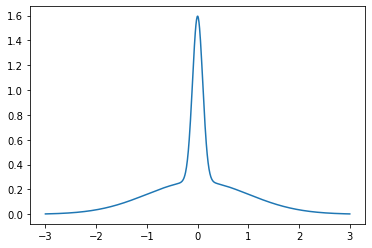

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def dist_calc(x, s, w, m):
    final_dist = w[0] * np.exp(-((x - m[0])/s[0])**2 / 2) / (s[0] * np.sqrt(2 * np.pi))
    for i in range(1,len(s)):
        final_dist += w[i] * np.exp(-((x - m[i])/s[i])**2 / 2) / (s[i] * np.sqrt(2 * np.pi))
    return final_dist

x = np.linspace(-3, 3, 1000)
s = [1, 1/10]
w = [2/3, 1/3]
x0 = [0, 0]

y = dist_calc(x, s, w, x0)

plt.plot(x, y)
plt.show()

In [11]:
distributions = [
    {"Name": "Gaussian", "s": 1, "w": 1, "x": 0},
    {"Name": "Skewed", "s": [1, 2/3, 5/9], "w": [1, 1, 3]/5, "x": [0, 1/2, 13/12]},
    {"Name": "Strongly skewed", "s": [(2/3)**i for i in range(0,8)], "w": [1/8]*8, "x": [3*((2/3)**i - 1) for i in range(0,8)]},
    {"Name": "Kurtotic", "s": [1, 1/10], "w": [2, 1]/3, "x": [0, 0]},
    {"Name": "Outliers", "s": [1, 1/10], "w": [1, 9]/10, "x": [0, 0]},

    {"Name": "Bimodal", "s": [2/3]*2, "w": [.5, .5], "x": [-1, 1]},
    {"Name": "Separated", "s": [.5, .5], "w": [.5, .5], "x": [-1.5, 1.5]},
    {"Name": "Asm. Bimodal", "s": [1, 1/3], "w": [.75, .25], "x": [0, 1.5]},
    {"Name": "Trimodal", "s": [.6, .6, .25], "w": [9, 9, 2]/20, "x": [-1.2, 1.2, 0]},
    {"Name": "Claw", "s": [1]+[.1]*5, "w": [.5]+[.1]*5, "x": [0]+[i/2-1 for i in range(0,10,2)]},

    {"Name": "Double Claw", "s": [2/3, 2/3]+[.01]*7, "w": [.49, .49]+[1/350]*7, "x": [-1, 1]+[i for i in [-1.5, 1.5]+[.5]*7]},
    {"Name": "Asymmetric Claw", "s": [1]+[2**i/10 for i in range(2,-3,-1)], "w": [1/2]+[2**i/31 for i in range(3,-2,-1)], "x": [0]+[i for i in range(-1.5, 2.6)]},
    {"Name": "Asm. Dbl. Claw", "s": [2/3, 2/3]+[.01]*3+[.07]*3, "w": [.46, .46]+[1/300]*3}
]

TypeError: unsupported operand type(s) for /: 'list' and 'int'